# fMRI data preprocessing - Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adasegroup/NEUROML2020/blob/seminar4/seminar-4/Introduction.ipynb)

fMRI scans are saved in dicom format. For scientific analysis of brain images the nifty format (.nii files) are often used.
The conversion from dicom to nifty can be done with [dcm2niix](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#Introduction) 

Many file are generated during fMRI sessions. These can arranged in many ways, thus a standard is needed how to arrange them. 
Commonly used standard is [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/).

You can use [HeuDiConv](https://heudiconv.readthedocs.io/en/latest/) or [Dcm2Bids](https://cbedetti.github.io/Dcm2Bids/tutorial/) to automate the conversion from dicom to BIDS.

![DICOM TO BIDS](https://www.incf.org/sites/default/files/articles/bids_standard-2.jpg)

Let's download the data we will be working with. We will download data through DataLad. It's destibuted data managements system, its provide data storage and version control.

http://www.datalad.org/ 

about the data, that we working with:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/

In [5]:
%%bash
sudo datalad get -J 20 -d /data/ds000114 \
    /data/ds000114/derivatives/fmriprep/sub-*/anat/*preproc.nii.gz \
    /data/ds000114/sub-*/ses-test/func/*fingerfootlips*

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


action summary:
  get (notneeded: 31)


Unfortunately this cell doesn't work properly when you deploy docker container on a mac with M* chip (I personally tried M1 and M1X and there were some troubles with it). In this case I recommend to use data from the archive. **NOTE** in case of using data from the archive you need to specify correct pathes in the proceeding cells.

In [6]:
from utils import list_files
# The data is already in BIDS format
# The subjects peformed 5 tasks. We will focus on fingerfootlips task
list_files('/data/ds000114/sub-01/ses-retest')

ses-retest/
    func/
        sub-01_ses-retest_task-linebisection_bold.nii.gz
        sub-01_ses-retest_task-fingerfootlips_bold.nii.gz
        sub-01_ses-retest_task-covertverbgeneration_bold.nii.gz
        sub-01_ses-retest_task-linebisection_events.tsv
        sub-01_ses-retest_task-overtwordrepetition_bold.nii.gz
        sub-01_ses-retest_task-overtverbgeneration_bold.nii.gz
    anat/
        sub-01_ses-retest_T1w.nii.gz
    dwi/
        sub-01_ses-retest_dwi.nii.gz


With nibabel we can load a file and inspect its properties.

In [11]:
import nibabel
from nilearn import plotting
import numpy as np
import warnings
warnings.filterwarnings('ignore')

anat = nibabel.load('/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz')
fmri = nibabel.load('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

print(f'Anatomical dimensionality is {anat.ndim} and fmri is {fmri.ndim}')
#The anatomical image have higher resolution then the fmri
print(f'Anatomical voxelization: {anat.shape}\nfMRI voxelization: {fmri.shape}')
#the data can be accessed as
print(f'\nAnatomical volume affine:\n{anat.affine}\nfMRI affine:\n{fmri.affine}')
data = np.array(anat.dataobj)

Anatomical dimensionality is 3 and fmri is 4
Anatomical voxelization: (256, 156, 256)
fMRI voxelization: (64, 64, 30, 184)

Anatomical volume affine:
[[ 9.99182463e-01 -5.10393567e-02  9.58159845e-03 -1.27317017e+02]
 [ 3.95217389e-02  1.29798853e+00 -2.68560350e-02 -8.03349991e+01]
 [-8.51583015e-03  3.53622437e-02  9.99593377e-01 -1.38213226e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
fMRI affine:
[[-3.99471426e+00 -2.04233140e-01  2.29353290e-02  1.30641693e+02]
 [-2.05448717e-01  3.98260689e+00 -3.10890853e-01 -9.74732285e+01]
 [ 6.95819734e-03  3.11659902e-01  3.98780894e+00 -8.06465759e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<OrthoSlicer3D: /data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz (256, 156, 256)>

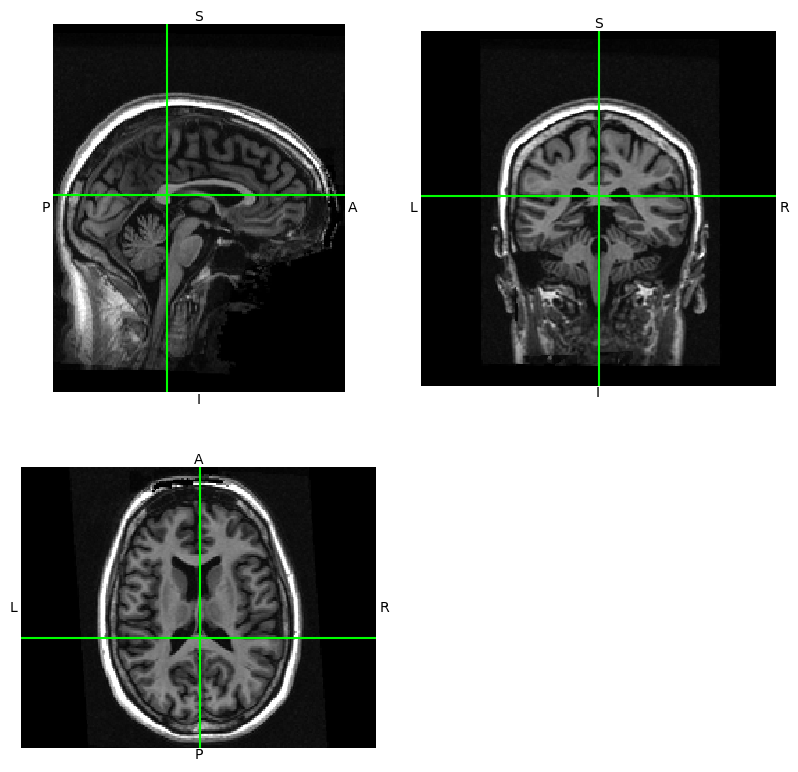

In [12]:
anat.orthoview()

<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz (64, 64, 30, 184)>

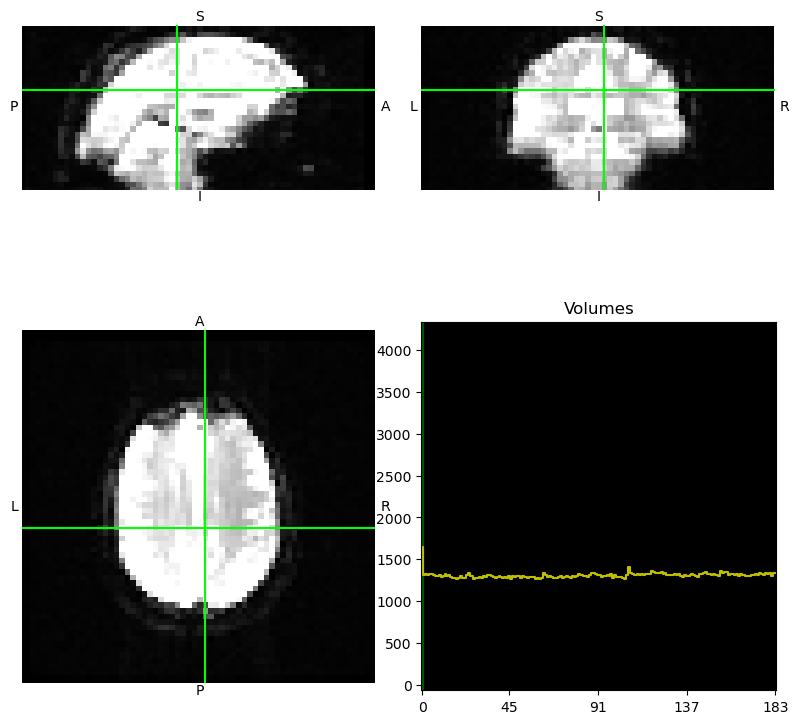

In [13]:
fmri.orthoview()

Lets stop on SliceTiming key, unlike a photograph, in which the entire picture is taken in a single moment, an fMRI volume is acquired in slices. Each of these slices takes time to acquire - from tens to hundreds of milliseconds.

The two most commonly used methods for creating volumes are sequential and interleaved slice acquisition. Sequential slice acquisition acquires each adjacent slice consecutively, either bottom-to-top or top-to-bottom. Interleaved slice acquisition acquires every other slice, and then fills in the gaps on the second pass. Both of these methods are illustrated in the video below.

https://www.brainvoyager.com/bv/doc/UsersGuide/Preprocessing/SliceScanTimeCorrection.html

![SliceTiming](https://andysbrainbook.readthedocs.io/en/latest/_images/SliceTimingCorrection_Demo.gif "slicetiming")

In [14]:
import json

#metadata is located in json files
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
task_info

{'EchoTime': 0.05,
 'FlipAngle': 90,
 'RepetitionTime': 2.5,
 'SliceTiming': [0.0,
  1.2499999999999998,
  0.08333333333333333,
  1.333333333333333,
  0.16666666666666666,
  1.4166666666666663,
  0.25,
  1.4999999999999996,
  0.3333333333333333,
  1.5833333333333328,
  0.41666666666666663,
  1.666666666666666,
  0.5,
  1.7499999999999993,
  0.5833333333333333,
  1.8333333333333326,
  0.6666666666666666,
  1.9166666666666659,
  0.75,
  1.9999999999999991,
  0.8333333333333333,
  2.083333333333332,
  0.9166666666666666,
  2.1666666666666656,
  1.0,
  2.249999999999999,
  1.0833333333333333,
  2.333333333333332,
  1.1666666666666665,
  2.416666666666665],
 'TaskName': 'finger_foot_lips'}

In [15]:
len(task_info['SliceTiming'])

30

# Introduction Nipype

**Why nipype?**

Nipype allows to build preprocessing pipelines from different softwares, and it is computationally efficient. There are some helpful ready to use pipleines written with Nipype like [fmriprep](https://fmriprep.org/en/stable/index.html). To use fmriprep the data have to be in valid BIDS format. The user have to supply only the path to the data setup the [parametars](https://fmriprep.org/en/stable/usage.html#command-line-arguments). 

In Nipype, interfaces are python modules that allow you to use various external packages (e.g. FSL, SPM or FreeSurfer), even if they themselves are written in another programming language than python. Such an interface knows what sort of options an external program has and how to execute it.

![Nipype architecture](https://raw.github.com/satra/intro2nipype/master/images/arch.png)

In Nipype, a node is an object that executes a certain function. This function can be anything from a Nipype interface to a user-specified function or an external script. Each node consists of a name, an interface category and at least one input field, and at least one output field.


Once you connect multiple nodes to each other, you create a directed graph. In Nipype we call such graphs either workflows or pipelines. Directed connections can only be established from an output field of a node to an input field of another node.

In [18]:
from nipype import Node, Function, Workflow
from IPython.display import Image, clear_output


def multiply(a, b):
    return a * b

#Create a Node that multiplies 2 numbers
mul = Node(Function(input_names=['a', 'b'],
                      output_names=['multiply_result'],
                      function=multiply), 
             name='a_x_b')

mul.inputs.a = 2
mul.inputs.b = 3

result = mul.run()
result.outputs

230922-21:01:31,979 nipype.workflow INFO:
	 [Node] Setting-up "a_x_b" in "/tmp/tmpnn7l0_rd/a_x_b".
230922-21:01:31,984 nipype.workflow INFO:
	 [Node] Executing "a_x_b" <nipype.interfaces.utility.wrappers.Function>
230922-21:01:31,987 nipype.workflow INFO:
	 [Node] Finished "a_x_b", elapsed time 0.000427s.



multiply_result = 6

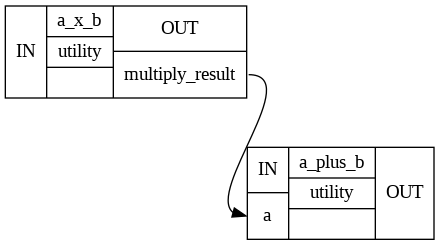

In [21]:
#Create a Node that adds 2 numbers
def add(a, b):
    return a + b



adder = Node(Function(input_names=['a', 'b'],
                      output_names=['add'],
                      function=add), 
             name='a_plus_b')
adder.inputs.b = 10

#Create a workflow 
wf = Workflow('hello')
# connect the nodes 
wf.connect(mul, 'multiply_result', adder, 'a')
#visualize the graph
wf.write_graph(graph2use='flat', format='png', simple_form=True)
clear_output()
Image(filename='graph_detailed.png')

In [22]:
#run the graph
eg = wf.run()
clear_output()#don't print the pipeline steps during exection
#check the results
eg = list(eg.nodes())
nodes_outputs = [node.result.outputs for node in eg]
nodes_outputs

[
 multiply_result = 6,
 
 add = 16]

**Dataset:**
[A test-retest fMRI dataset for motor, language and spatial attention functions](https://openneuro.org/datasets/ds000114/versions/1.0.1)

**About nipype**
https://www.frontiersin.org/articles/10.3389/fninf.2011.00013/full

**Thanks to Michael Notter for the wonderful [nipype tutorial](https://miykael.github.io/nipype_tutorial/)**

In [23]:
!echo $FSLDIR